### TEST 86% ACCURACY

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 1, 64)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 1, 64)         256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 1, 128)         0         
 g2D)                                                            
                                                        

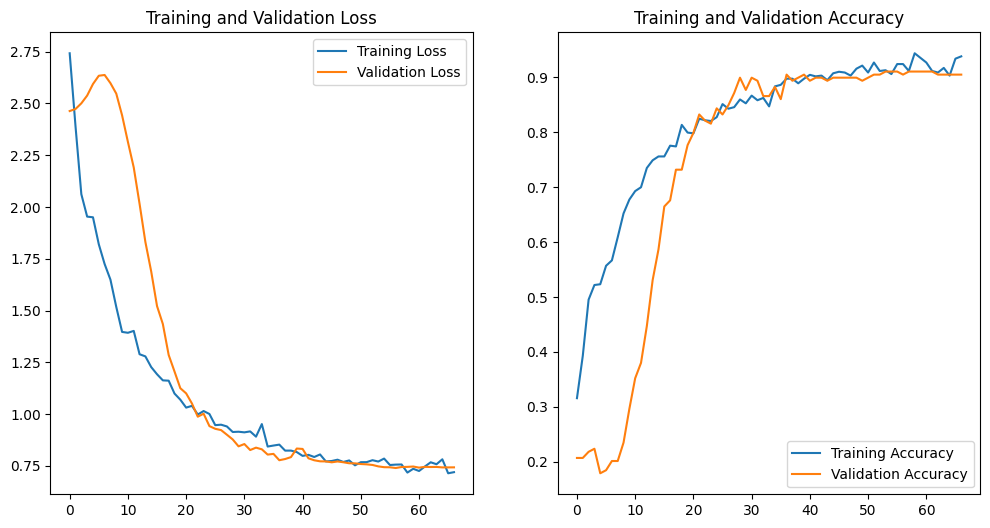

/Users/danielporras/Musica/new_env_3_10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, f1_score, classification_report

DATA_PATH = "/Users/danielporras/Musica/music_x/data.json"

def add_noise(data):
    noise_factor = 0.003 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])

    from imblearn.over_sampling import SMOTE

    # Assume X is your feature matrix and y are your labels
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(7, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.0003)

    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

# Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Display confusion matrix
    cm_df = pd.DataFrame(cm, index=[f'True {i}' for i in range(8)], columns=[f'Predicted {i}' for i in range(8)])

    print("Confusion Matrix:")
    print(cm_df)

    # Rest of the code for precision, F1 score, classification report, and loss curves
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    report = classification_report(y_test, y_pred)
    print(report)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()
    
model.save('/Users/danielporras/Musica/music_x/best_model.h5')


### H6 Model time shift data

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 1, 64)         0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 13, 1, 64)         256       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 1, 128)         0         
 g2D)                                                            
                                                      

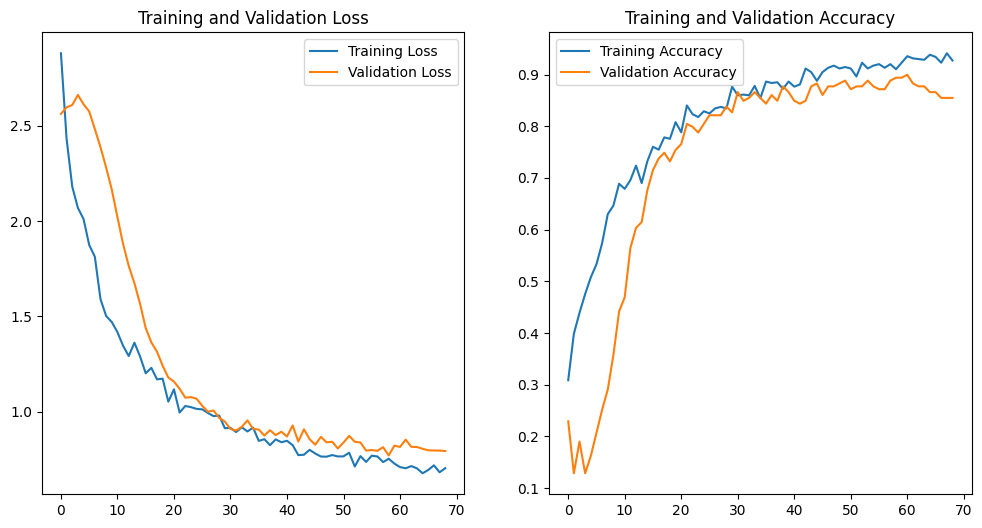

INFO:tensorflow:Assets written to: /Users/danielporras/Musica/music_x/best_model.h6/assets


INFO:tensorflow:Assets written to: /Users/danielporras/Musica/music_x/best_model.h6/assets


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers

DATA_PATH = "/Users/danielporras/Musica/music_x/data.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.0003)

    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Plotting the training and validation loss curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

model.save('/Users/danielporras/Musica/music_x/best_model.h6')

    


### H5 Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 1, 64)         0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 13, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 1, 128)         0         
 g2D)                                                            
                                                      

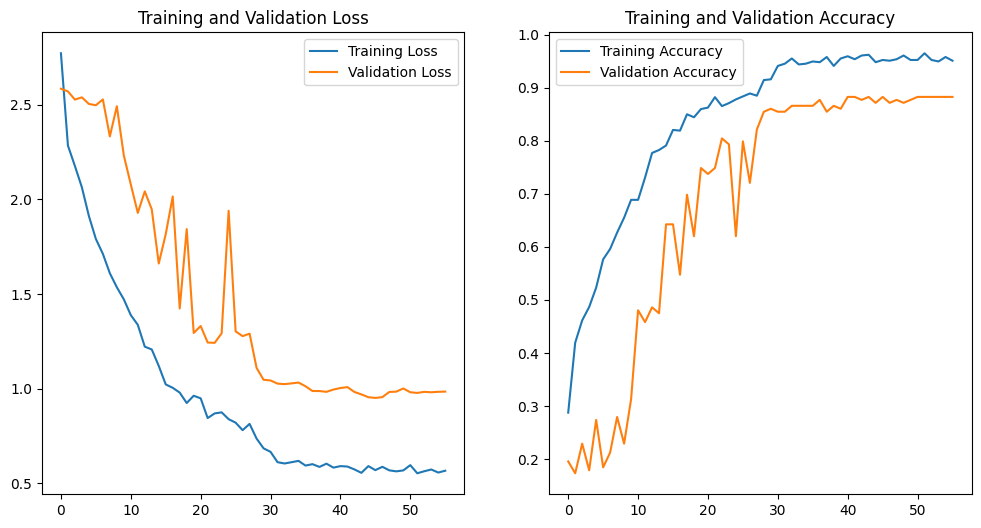

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import precision_score, f1_score, classification_report

DATA_PATH = "/Users/danielporras/Musica/music_x/data.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.11))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0003)
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Compute precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    # Compute F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    # Print a detailed classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plotting the training and validation loss curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()



In [4]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/Users/danielporras/Musica/music_x/best_model.h5')

# Get the output layer
output_layer = loaded_model.layers[-1]

# Print the number of units in the output layer
print(output_layer.units)

7


In [5]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/Users/danielporras/Musica/music_x/best_model.h5')

### Test with different data base

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers

DATA_PATH = "/Users/danielporras/Musica/music_x/data_shifted.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0003)
    
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

        # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Compute precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    # Compute F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    # Print a detailed classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Plotting the training and validation loss curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/danielporras/Musica/music_x/data_shifted.json'

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 1, 64)         0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 13, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 1, 128)         0         
 g2D)                                                            
                                                      

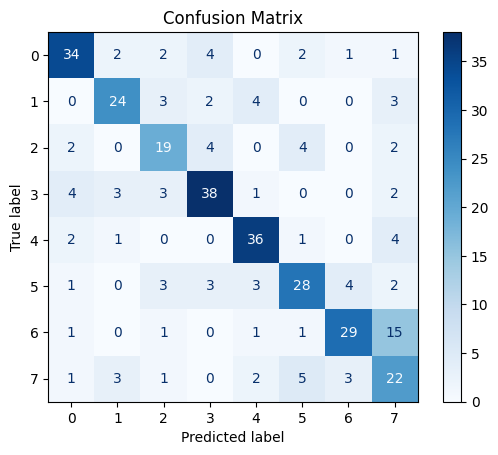

Precision: 0.6963707353712172
F1 Score: 0.6859640374382305
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        46
           1       0.73      0.67      0.70        36
           2       0.59      0.61      0.60        31
           3       0.75      0.75      0.75        51
           4       0.77      0.82      0.79        44
           5       0.68      0.64      0.66        44
           6       0.78      0.60      0.68        48
           7       0.43      0.59      0.50        37

    accuracy                           0.68       337
   macro avg       0.69      0.68      0.68       337
weighted avg       0.70      0.68      0.69       337



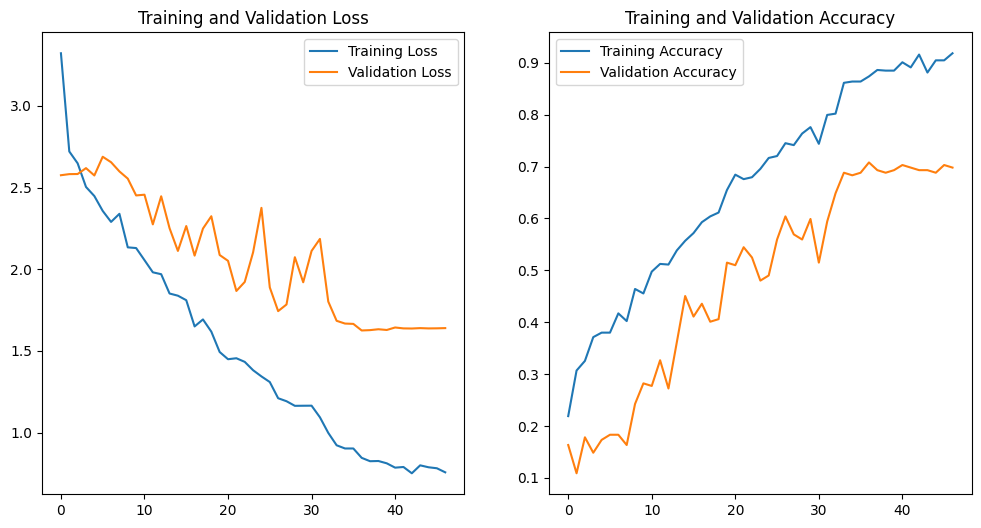

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import json

DATA_PATH = "/Users/danielporras/Musica/music_x/random_data.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
    
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7])
    disp.plot(cmap='Blues', values_format='d')

    plt.title('Confusion Matrix')
    plt.show()

    # Rest of the code for precision, F1 score, classification report, and loss curves
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    report = classification_report(y_test, y_pred)
    print(report)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()


### Fine tune with sample weights

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 13, 1, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_30 (Ba  (None, 13, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 7, 1, 128)         0         
 ng2D)                                                           
                                                      

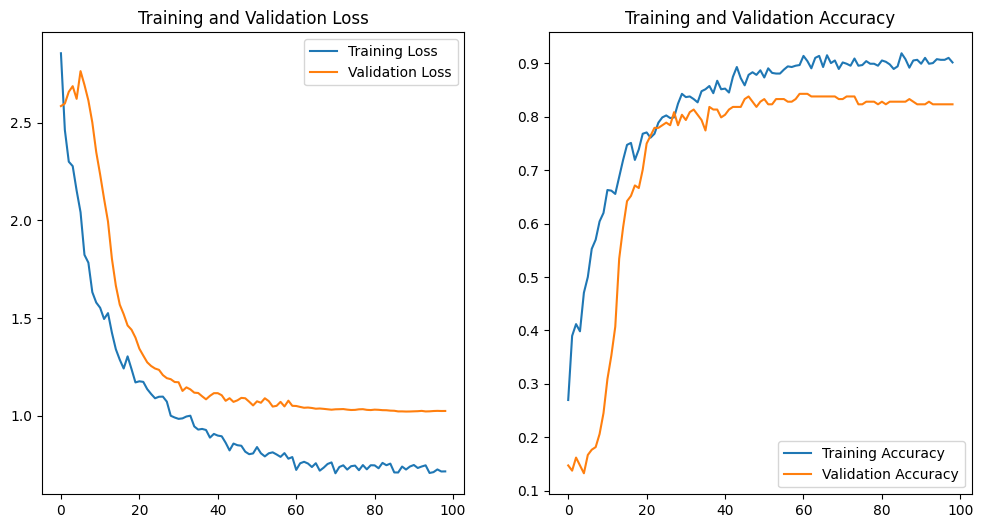

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers

DATA_PATH = "/Users/danielporras/Musica/music_x/data_shifted.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Calculate sample weights based on inverse class frequencies
    sample_weights = compute_sample_weight('balanced', y_train)
    sample_weight_dict = dict(enumerate(sample_weights))

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0003)
    
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping], sample_weight=sample_weights)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Display confusion matrix
    cm_df = pd.DataFrame(cm, index=[f'True {i}' for i in range(8)], columns=[f'Predicted {i}' for i in range(8)])

    print("Confusion Matrix:")
    print(cm_df)

    # Rest of the code for precision, F1 score, classification report, and loss curves
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    report = classification_report(y_test, y_pred)
    print(report)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()
   


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 13, 1, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_36 (Ba  (None, 13, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 1, 128)         0         
 ng2D)                                                           
                                                      

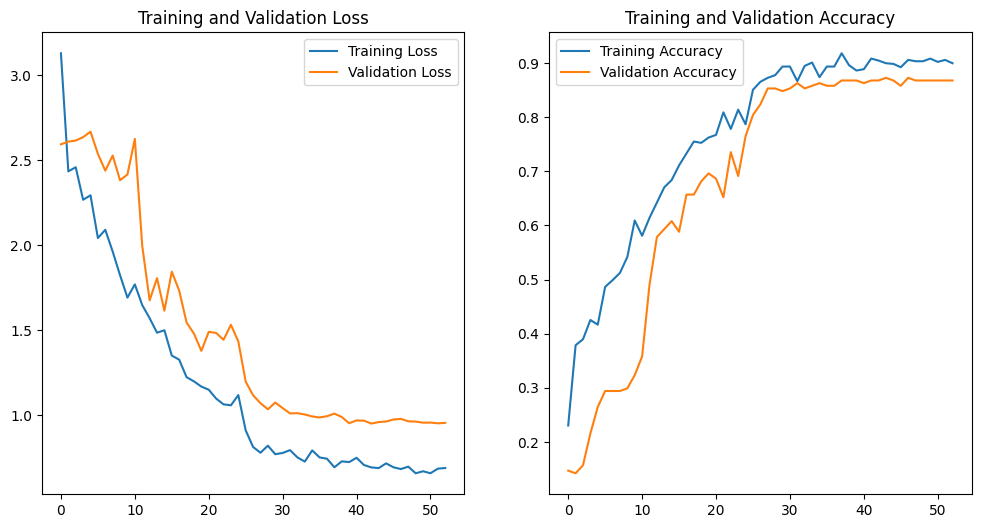

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers

DATA_PATH = "/Users/danielporras/Musica/music_x/data_shifted.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Calculate sample weights based on inverse class frequencies
    sample_weights = compute_sample_weight('balanced', y_train)
    sample_weight_dict = dict(enumerate(sample_weights))

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0003)
    
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping], sample_weight=sample_weights)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Display confusion matrix in tabular format
    cm_df = pd.DataFrame(cm, index=[f'True {i}' for i in range(8)], columns=[f'Predicted {i}' for i in range(8)])

    print("Confusion Matrix:")
    print(cm_df)

    # Rest of the code for precision, F1 score, classification report, and loss curves
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    report = classification_report(y_test, y_pred)
    print(report)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()


### Add SMOTE to balance code

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 13, 1, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_42 (Ba  (None, 13, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_29 (Conv2D)          (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 7, 1, 128)         0         
 ng2D)                                                           
                                                      

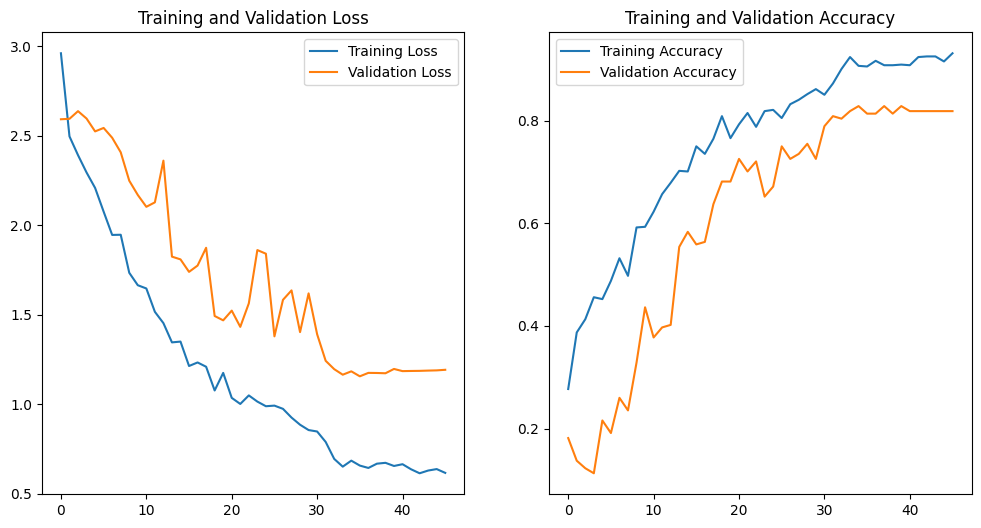

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers

DATA_PATH = "/Users/danielporras/Musica/music_x/random_data.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Use SMOTE to balance the dataset
    smote = SMOTE()
    X, y = smote.fit_resample(X.reshape(X.shape[0], -1), y)
    
    # Convert data["features"] to a numpy array before accessing its shape
    features_array = np.array(data["features"])
    X = X.reshape(X.shape[0], features_array.shape[1])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

# Rest of your code remains the same

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Calculate sample weights based on inverse class frequencies
    sample_weights = compute_sample_weight('balanced', y_train)
    sample_weight_dict = dict(enumerate(sample_weights))

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0003)
    
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping], sample_weight=sample_weights)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Display confusion matrix in tabular format
    cm_df = pd.DataFrame(cm, index=[f'True {i}' for i in range(8)], columns=[f'Predicted {i}' for i in range(8)])

    print("Confusion Matrix:")
    print(cm_df)

    # Rest of the code for precision, F1 score, classification report, and loss curves
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    report = classification_report(y_test, y_pred)
    print(report)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()


### LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 1, 64)         640       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 13, 1, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_30 (Ba  (None, 13, 1, 64)         256       
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 1, 128)        73856     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 7, 1, 128)         0         
 ng2D)                                                           
                                                      

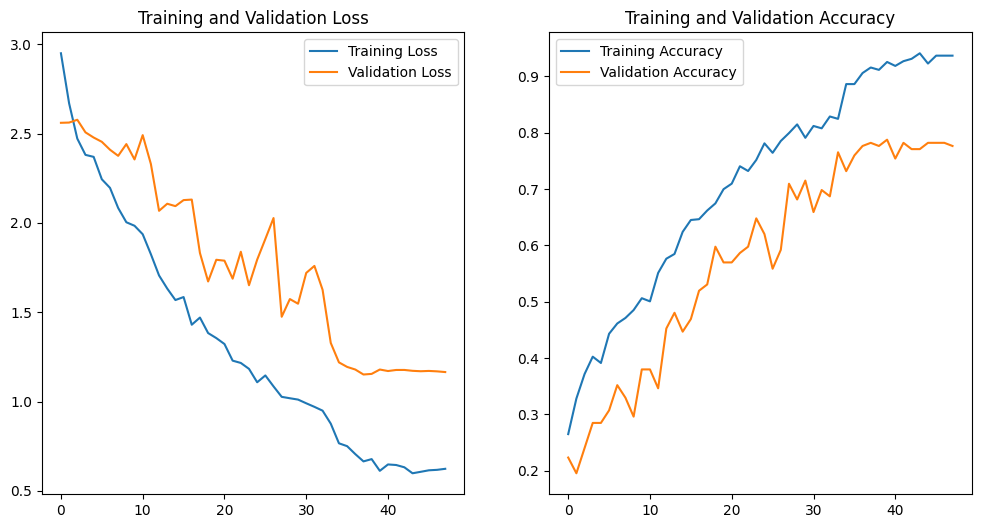

In [ ]:
from tensorflow.keras.layers import LSTM
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers

DATA_PATH = "/Users/danielporras/Musica/music_x/random_data.json"

def add_noise(data):
    noise_factor = 0.002 * np.random.randn(*data.shape)
    data_noise = data + noise_factor
    return data_noise

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["features"])
    y = np.array(data["labels"])
    
    # Use SMOTE to balance the dataset
    smote = SMOTE()
    X, y = smote.fit_resample(X.reshape(X.shape[0], -1), y)
    
    # Convert data["features"] to a numpy array before accessing its shape
    features_array = np.array(data["features"])
    X = X.reshape(X.shape[0], features_array.shape[1])
    
    # Add noise to a random subset of the data
    indices = np.random.randint(0, X.shape[0], size=int(X.shape[0] * 0.12))
    X[indices] = add_noise(X[indices])
    
    return X, y

# Rest of your code remains the same

def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Reshape the data to 4D (num_samples, num_features, 1, 1) for Conv2D
    X_train = X_train[..., np.newaxis, np.newaxis]
    X_validation = X_validation[..., np.newaxis, np.newaxis]
    X_test = X_test[..., np.newaxis, np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model_v3(input_shape, dropout_rate=0.4, l2_regularizer=0.0005):
    model = tf.keras.Sequential()

    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(64))

    model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())  # Move batch normalization after activation
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(8, activation='softmax'))

    return model

if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Calculate sample weights based on inverse class frequencies
    sample_weights = compute_sample_weight('balanced', y_train)
    sample_weight_dict = dict(enumerate(sample_weights))

    # Adjust dropout and regularization parameters
    model = build_model_v2(input_shape, dropout_rate=0.4, l2_regularizer=0.0005)

    optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0003)
    
    # Use learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
    
    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                        batch_size=32, epochs=100, callbacks=[lr_scheduler, early_stopping], sample_weight=sample_weights)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Compute predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

    # Display confusion matrix in tabular format
    cm_df = pd.DataFrame(cm, index=[f'True {i}' for i in range(8)], columns=[f'Predicted {i}' for i in range(8)])

    print("Confusion Matrix:")
    print(cm_df)

    # Rest of the code for precision, F1 score, classification report, and loss curves
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}')

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

    report = classification_report(y_test, y_pred)
    print(report)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()


In [ ]:
import os

def get_dir_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

directory_size_bytes = get_dir_size('/Users/danielporras/Musica/music_import/Music')
directory_size_MB = directory_size_bytes * 1.0E-6
directory_size_GB = directory_size_bytes * 1.0E-9

print(f"The size of the directory is {directory_size_bytes} bytes, {directory_size_MB} MB, or {directory_size_GB} GB")

The size of the directory is 1838463027 bytes, 1838.463027 MB, or 1.8384630270000002 GB
